In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

#pre-processing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

# K-Means
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse

# random forest
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# KNN
from sklearn.neighbors import KNeighborsClassifier

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import warnings
warnings.filterwarnings('ignore')

# decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# model building
from sklearn.model_selection import train_test_split, GridSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, mean_squared_error

# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

# set seed for reproducible results
RSEED = 10


# Section A

### Weather:  provided the weather data of each weather station

#### Variables:

1) **station_nbr** - station id

2) **date** - the date of measurement

3) **tmax** - maximum temperature 

4) **tmin** - minimum temperature

5) **tavg** - average temperature

6) **depart** - temperature departure from the normal indicates if the dekadal average temperatures were above or below the 30-year normal.

7) **dewpoint**- the average of dewpint -- dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%.

8) **wetbulb**- the average of wetbulb -- the wet-bulb temperature is the lowest temperature that can be reached under current ambient conditions by the evaporation of water only

9) **heat** - HEATING (SEASON BEGINS WITH JULY) 

10) **cool** - COOLING (SEASON BEGINS WITH JANUARY) 

11) **sunrise** - SUNRISE HH:MM (Calculated, not observed)

12) **sunset** - SUNSET HH:MM (Calculated, not observed)

13) **codesum** - Weather Phenomena 

14) **snowfall** - amount of snow (INCHES)

15) **preciptotal** - INCHES (24-HR PERIOD ENDING AT INDICATED LOCAL STANDARD TIME) 

16) **stnpressure** - AVERAGE STATION PRESSURE 

17) **sealevel** - AVERAGE SEA LEVEL PRESSURE 

18) **resultspeed** - WIND SPEED  - SPEED IN MILES PER HOUR  DIRECTION TO TENS OF DEGREES 

19) **resultdir** - RESULTANT DIRECTION (WHOLE DEGREES) 

20) **avgspeed** - AVERAGE WIND SPEED 

#### Values: 

T = TRACE 
M = MISSING DATA 

### Sales: provided with sales data for 111 products whose  sales may be affected by the weather

#### Variables:

1) **store_nbr** - store id

2) **item_nbr** - item id

3) **units** - amount of units

### Keys:  The key data indicates for each store to which weather station it belongs.

#### Variables:

1) **store_nbr** - store id

2) **station_nbr** - station id

<div style= "font-size:18px;"> <b>Helper functions: </b></div>

In [192]:
# The function get DF and list of features and make the type of them to numeric
def df_to_numeric(original_df,features_list): 
    df = original_df.copy(deep=True)
    for feature in features_list:
        if feature=='date':
            df[feature] = pd.to_datetime(original_df[feature])
        else: 
            df[feature] = pd.to_numeric(original_df[feature],downcast='float')
    return df

# The function get DF make all the columns type of object
def df_to_object(original_df):
    features_list = original_df.columns
    df = original_df.copy(deep=True)
    for feature in features_list:
        df[feature] = pd.to_numeric(original_df[feature],downcast='object')
    return df

#Function for calculating measures on classfiction section
def get_metrics(y_test, y_pred):
    
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # get confusion matrix
    mat = metrics.confusion_matrix(y_test, y_pred)
    true_neg, false_pos, false_neg, true_pos = mat.ravel()
    
    # calculate sensitivity and specificity
    sensitivity = round(true_pos / np.sum(actual_pos), 3)
    specificity = round(true_neg / np.sum(actual_neg), 3)
    
    return sensitivity, specificity

<div style= "font-size:18px;"> <b>Import the data: </b></div>
<div style="direction:rtl; font-size:15px;">  בחלק זה אנו מציגים את המידע שיש בכל אחד מהמסדי הנתונים ומדפיסים מידע אודותיהם</div>

In [193]:
df_weather = pd.read_csv('weather.csv')
df_key = pd.read_csv('key.csv')
df_sales = pd.read_csv('sales.csv')

In [194]:
df_weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


In [195]:
df_weather.shape #The number of records and features we have in the data

(20517, 20)

In [196]:
df_weather.describe() #Statistics on numerical variables

,station_nbr
count,20517.000000
mean,10.549057
std,5.768533
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,20.000000


In [197]:
df_weather.dtypes #Types of variables we have in data

station_nbr     int64
date           object
tmax           object
tmin           object
tavg           object
depart         object
dewpoint       object
wetbulb        object
heat           object
cool           object
sunrise        object
sunset         object
codesum        object
snowfall       object
preciptotal    object
stnpressure    object
sealevel       object
resultspeed    object
resultdir      object
avgspeed       object
dtype: object

In [198]:
df_sales.head() # Print the head of the data

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0
1,2012-01-01,1,2,0
2,2012-01-01,1,3,0
3,2012-01-01,1,4,0
4,2012-01-01,1,5,0


In [199]:
df_sales.shape 

(4617600, 4)

In [200]:
df_sales.describe()

,store_nbr,item_nbr,units
count,4.617600e+06,4.617600e+06,4.617600e+06
mean,2.309108e+01,5.600000e+01,9.868756e-01
std,1.295281e+01,3.204164e+01,9.875798e+00
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.200000e+01,2.800000e+01,0.000000e+00
50%,2.300000e+01,5.600000e+01,0.000000e+00
75%,3.400000e+01,8.400000e+01,0.000000e+00
max,4.500000e+01,1.110000e+02,5.568000e+03


In [201]:
df_sales.dtypes

date         object
store_nbr     int64
item_nbr      int64
units         int64
dtype: object

In [202]:
df_key.head()

,store_nbr,station_nbr
0,1,1
1,2,14
2,3,7
3,4,9
4,5,12


In [203]:
df_key.shape 

(45, 2)

In [204]:
df_key.describe()

,store_nbr,station_nbr
count,45.000000,45.000000
mean,23.000000,11.266667
std,13.133926,5.019960
min,1.000000,1.000000
25%,12.000000,7.000000
50%,23.000000,12.000000
75%,34.000000,15.000000
max,45.000000,20.000000


In [205]:
df_key.dtypes

store_nbr      int64
station_nbr    int64
dtype: object

In [206]:
df_weather.replace({'M': None}, inplace=True) #Change variable M in the data to None
df = df_weather.copy(deep=True) #Placement of df_weather to df

features = ['date','tavg','dewpoint','wetbulb','sealevel','avgspeed','tmax'] # The intersting features
# Turn the features to numeric type
for feature in features:
    if feature=='date':
        df[feature] = pd.to_datetime(df_weather[feature]) #change features of type date to dateTime
    else: 
        df[feature] = pd.to_numeric(df_weather[feature],downcast='float')

In [207]:
df.dtypes #סוגי משתנים שיש לנו בדאטה

station_nbr             int64
date           datetime64[ns]
tmax                  float32
tmin                   object
tavg                  float32
depart                 object
dewpoint              float32
wetbulb               float32
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
snowfall               object
preciptotal            object
stnpressure            object
sealevel              float32
resultspeed            object
resultdir              object
avgspeed              float32
dtype: object

# Visualization

<div style="direction:rtl; font-size:15px;text-align:center"> תרשים זה מראה את תדירות תופעות מזג האוויר בכל שנה:</div>

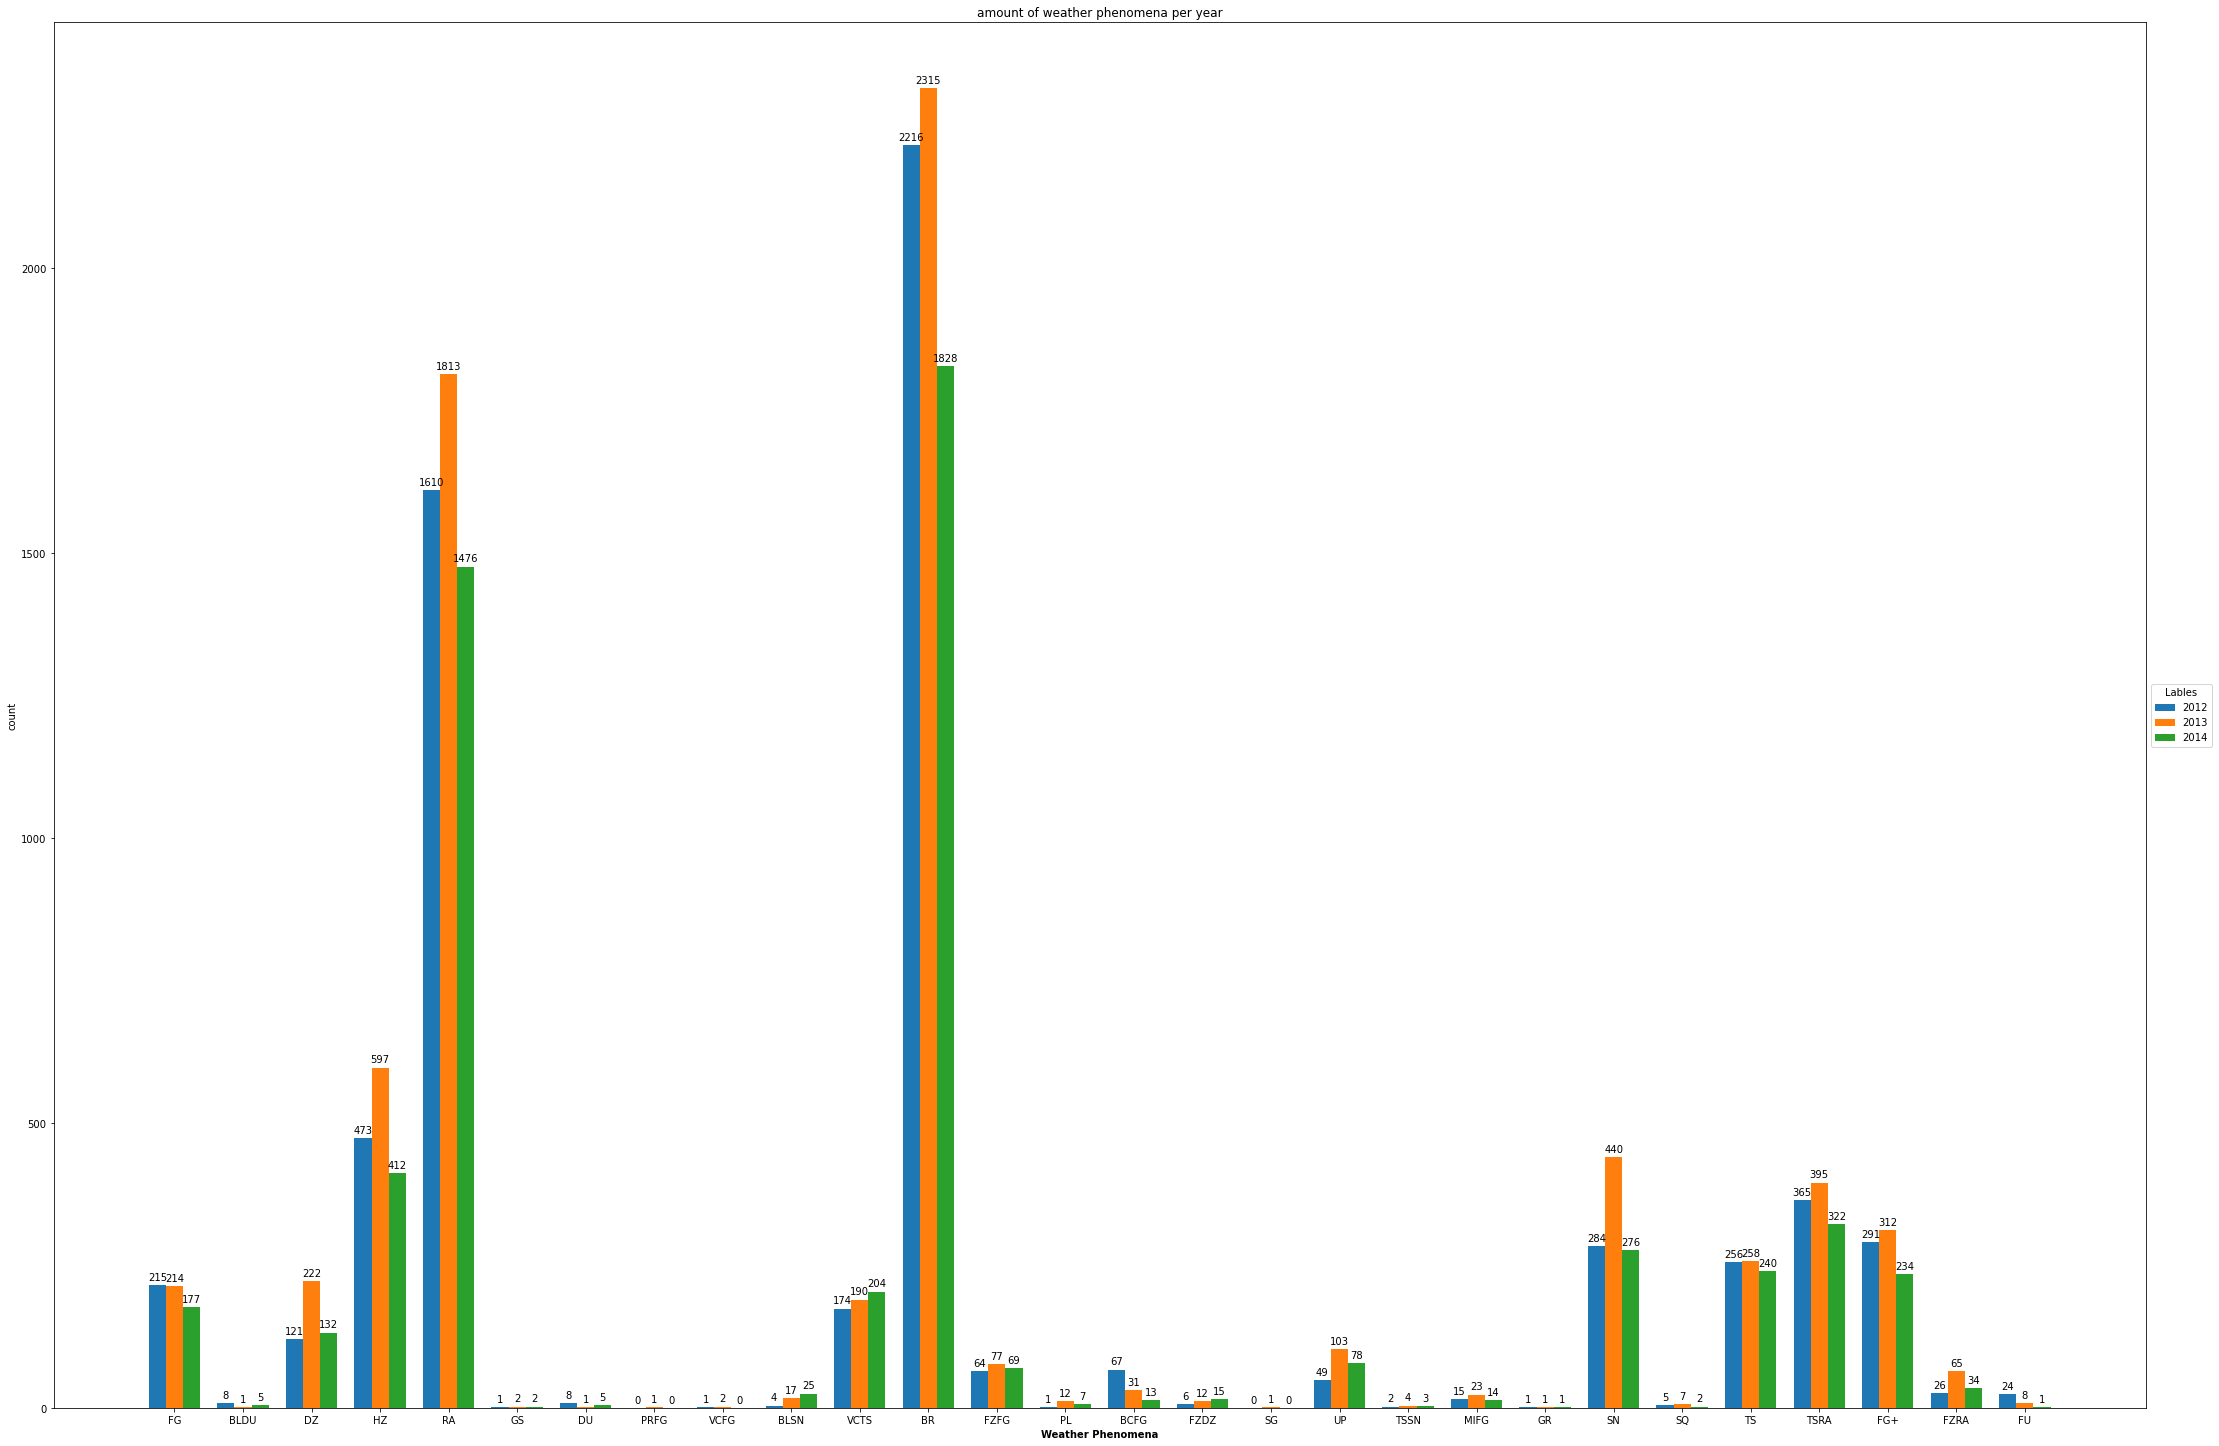

In [208]:
#Frequency of types of weather phenomena that occur each year

labels = df['codesum'].tolist()
codesum_labels=[]
for lab in labels:
    for l in lab.split():
        codesum_labels.append(l)        
codesum_labels=list(set(codesum_labels)) # get all the kinds of codesum from the db

years=['2012','2013','2014']

# count the codesum for each year
counts_2012= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
counts_2013= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
counts_2014= [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

for row in df.itertuples():
    for code in codesum_labels:
        if(code in row[13].split()):
            if(row[2].year==2012):
                counts_2012[codesum_labels.index(code)]+=1
            if(row[2].year==2013):
                counts_2013[codesum_labels.index(code)]+=1
            if(row[2].year==2014):
                counts_2014[codesum_labels.index(code)]+=1

x = np.arange(len(codesum_labels))  # the label locations
width = 0.25  # the width of the bars

r1 = np.arange(len(codesum_labels))
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]

fig, ax = plt.subplots(figsize=(30,20))
rects1 = ax.bar(r1, counts_2012, width, label='2012')
rects2 = ax.bar(r2, counts_2013, width, label='2013')
rects3 = ax.bar(r3, counts_2014, width, label='2014')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_title('amount of weather phenomena per year')

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
fig.tight_layout()

ax.legend(years,
          title="Lables",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.xlabel('Weather Phenomena', fontweight='bold')
plt.xticks([r + width for r in range(len(codesum_labels))], codesum_labels)

plt.show()

<div style="direction:rtl; font-size:15px;text-align:center">: תרשים זה מראה את התפלגות פיצרים מסויימים בין חמש תחנות אקראיות שבחרנו</div>

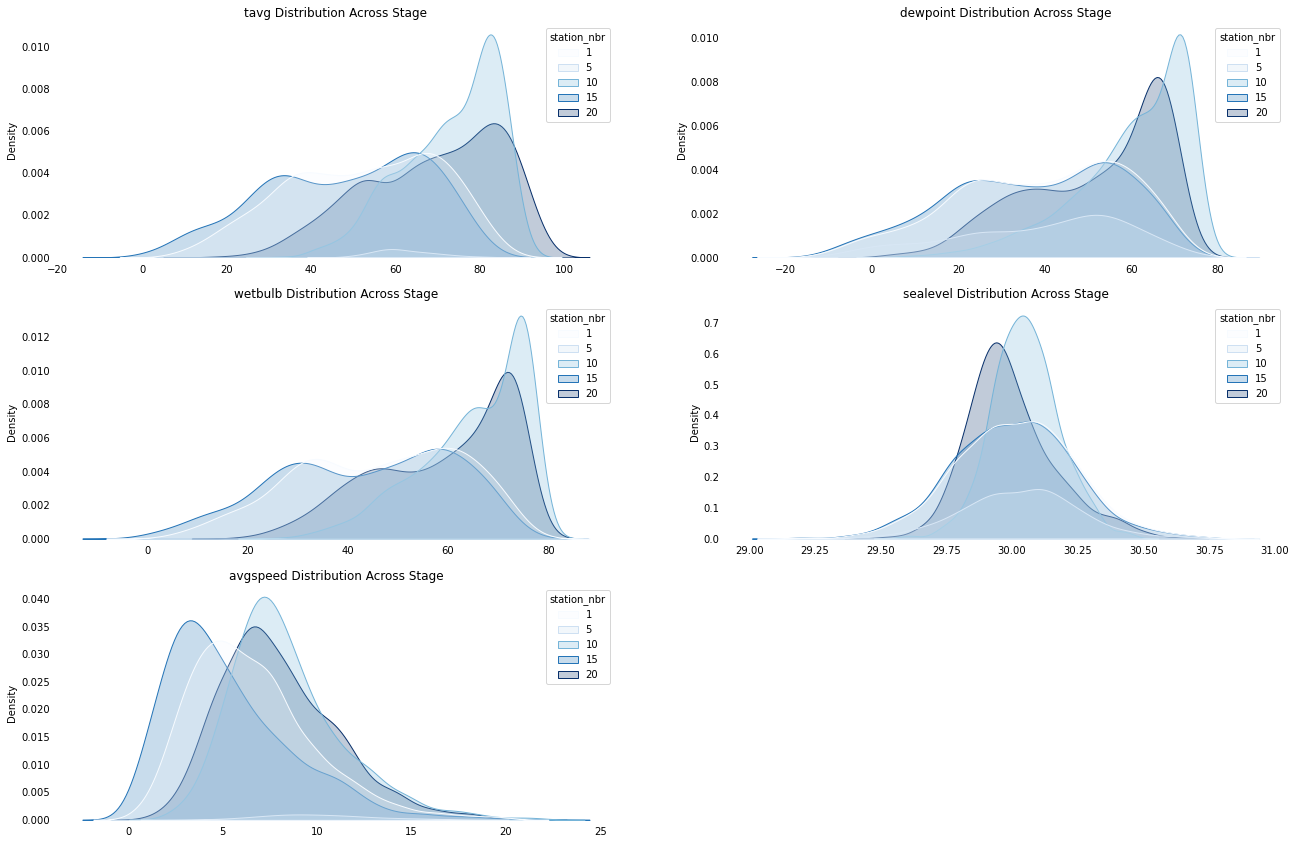

In [209]:
# plot distribution plots for numerical variables

df = df[df['station_nbr'].isin([1,5,10,15,20])] # only show 5 station for example

plt.figure(figsize=(22, 25))
numeric_features = df[["tavg", "dewpoint","wetbulb","sealevel","avgspeed"]]

for i in numeric_features:
    plt.subplot(5, 2, numeric_features.columns.get_loc(i)+1)
    sns.kdeplot(df[i], hue=df['station_nbr'], fill=True, palette='Blues', common_norm=True,warn_singular=False)
    sns.despine(top=True, right=True, bottom=True, left=True)
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
    plt.xlabel('')
    plt.title(i + ' Distribution Across Stage')


<div style="direction:rtl; font-size:15px;"> איחדנו את המסדי הנתונים על מנת לקבל מידע על המכירות </div>

In [210]:
#Merge all the data tables together 

result= pd.merge(left = df_sales, right = df_key, how = 'inner' , on = 'store_nbr')
df_merge=pd.merge(left = result, right = df_weather, how = 'inner' , on = ['station_nbr','date'])
df_merge.drop(['item_nbr'], axis=1, inplace=True)
df_merge

,date,store_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,1,0,1,52,31,42,None,36,40,...,-,-,RA FZFG BR,None,0.05,29.78,29.92,3.6,20,4.6
1,2012-01-01,1,0,1,52,31,42,None,36,40,...,-,-,RA FZFG BR,None,0.05,29.78,29.92,3.6,20,4.6
2,2012-01-01,1,0,1,52,31,42,None,36,40,...,-,-,RA FZFG BR,None,0.05,29.78,29.92,3.6,20,4.6
3,2012-01-01,1,0,1,52,31,42,None,36,40,...,-,-,RA FZFG BR,None,0.05,29.78,29.92,3.6,20,4.6
4,2012-01-01,1,0,1,52,31,42,None,36,40,...,-,-,RA FZFG BR,None,0.05,29.78,29.92,3.6,20,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617595,2014-10-31,35,0,5,None,None,None,None,37,None,...,0616,1640,,None,None,None,30.01,10.8,05,None
4617596,2014-10-31,35,0,5,None,None,None,None,37,None,...,0616,1640,,None,None,None,30.01,10.8,05,None
4617597,2014-10-31,35,0,5,None,None,None,None,37,None,...,0616,1640,,None,None,None,30.01,10.8,05,None
4617598,2014-10-31,35,0,5,None,None,None,None,37,None,...,0616,1640,,None,None,None,30.01,10.8,05,None


In [211]:
df_merge.replace({'M': None}, inplace=True) # for missing data
df_merge.replace({'-':None}, inplace=True) # for sunset and sunrise nulls
df_merge.replace({' ':None}, inplace=True) # for codesum nulls

features = ['date','tavg','dewpoint','wetbulb','sealevel','avgspeed','depart','stnpressure','heat','cool','resultspeed',
           'resultdir','station_nbr']

for feature in features:
    if feature=='date':
        df_merge[feature] = pd.to_datetime(df_merge[feature])
    else: 
        df_merge[feature] = pd.to_numeric(df_merge[feature],downcast='float')
        

In [212]:
# Function we built that if the column value is a number, then summed the values (Units),
#otherwise returns the value itself

def return_value(x):
    if(isinstance(list(x)[0], (int, np.integer))):
        return sum(list((x)))       
    else:
        return list(x)[0]

df_merge = df_merge.groupby(['date','store_nbr'],as_index=False).agg(lambda x: return_value(x))

In [213]:
df_merge

,date,store_nbr,units,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,1,32,1.0,52,31,42.0,NaN,36.0,40.0,...,None,None,RA FZFG BR,None,0.05,29.780001,29.920000,3.600000,20.0,4.6
1,2012-01-01,2,406,14.0,50,34,42.0,5.0,25.0,35.0,...,0739,1729,None,0.0,0.00,29.129999,30.520000,11.400000,32.0,11.3
2,2012-01-01,3,326,7.0,50,33,42.0,NaN,26.0,35.0,...,None,None,None,0.0,0.00,29.150000,30.540001,10.300000,32.0,10.2
3,2012-01-01,4,82,9.0,34,19,27.0,NaN,17.0,23.0,...,None,None,UP,None,T,29.340000,30.090000,22.799999,30.0,22.5
4,2012-01-01,5,41,12.0,72,48,60.0,NaN,54.0,57.0,...,None,None,FG+ FG BR,0.0,0.00,30.150000,30.190001,4.400000,25.0,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,2014-10-31,41,52,12.0,75,60,68.0,NaN,53.0,59.0,...,None,None,BR,0.0,0.00,29.799999,29.850000,7.000000,32.0,7.5
41596,2014-10-31,42,64,14.0,60,38,49.0,-7.0,31.0,42.0,...,0651,1737,None,0.0,0.00,28.980000,30.360001,11.900000,1.0,12.5
41597,2014-10-31,43,48,11.0,75,50,63.0,-2.0,53.0,57.0,...,0640,1740,None,0.0,0.00,29.820000,29.850000,5.300000,30.0,6.1
41598,2014-10-31,44,87,12.0,75,60,68.0,NaN,53.0,59.0,...,None,None,BR,0.0,0.00,29.799999,29.850000,7.000000,32.0,7.5


In [214]:
df_merge.shape 

(41600, 22)

In [215]:
df_merge.describe()

,store_nbr,units,station_nbr,tavg,depart,dewpoint,wetbulb,heat,cool,stnpressure,sealevel,resultspeed,resultdir,avgspeed
count,41600.000000,41600.000000,41600.000000,39909.000000,13942.000000,40780.000000,40091.000000,39909.000000,39909.000000,40610.000000,39666.000000,40920.000000,40920.000000,40686.000000
mean,23.091082,109.543197,11.323293,61.182941,1.752977,46.068563,53.205333,9.629683,5.812624,28.773385,30.015201,6.422996,18.336975,8.038657
std,12.952962,85.852619,4.946943,18.695539,7.700845,19.335122,16.710274,13.320545,7.754743,1.773351,0.190030,4.229074,9.704770,3.952521
min,1.000000,0.000000,1.000000,-16.000000,-32.000000,-24.000000,-15.000000,0.000000,0.000000,23.719999,29.160000,0.000000,1.000000,0.000000
25%,12.000000,54.000000,7.000000,48.000000,-3.000000,31.000000,41.000000,0.000000,0.000000,28.770000,29.900000,3.200000,13.000000,5.200000
50%,23.000000,93.000000,12.000000,64.000000,2.000000,49.000000,56.000000,1.000000,0.000000,29.340000,30.010000,5.600000,18.000000,7.300000
75%,34.000000,142.000000,15.000000,77.000000,6.000000,63.000000,68.000000,17.000000,12.000000,29.799999,30.129999,8.800000,25.000000,10.200000
max,45.000000,5613.000000,20.000000,100.000000,33.000000,77.000000,80.000000,81.000000,35.000000,30.610001,30.799999,28.400000,36.000000,28.700001


In [216]:
df_merge.dtypes

date           datetime64[ns]
store_nbr               int64
units                   int64
station_nbr           float64
tmax                   object
tmin                   object
tavg                  float64
depart                float64
dewpoint              float64
wetbulb               float64
heat                  float64
cool                  float64
sunrise                object
sunset                 object
codesum                object
snowfall               object
preciptotal            object
stnpressure           float64
sealevel              float64
resultspeed           float64
resultdir             float64
avgspeed              float64
dtype: object

<div style="direction:rtl; font-size:15px;text-align:center">כמות המכירות בימים גשומים לעומת ימים לא גשומים:</div>

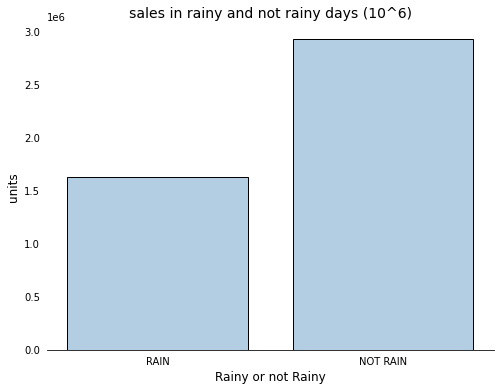

In [217]:
#The amount of sales on rainy days compared to non-rainy days

df = df_merge.copy(deep=True)

# מחליף את T במספר קטן מאוד אך עדיין גדול מ-0 רק בשביל הספירה
df.replace({' T':float(0.0001)}, inplace=True)
df.replace({'T':float(0.0001)}, inplace=True)
df.replace({'  T':float(0.0001)}, inplace=True)

df['preciptotal'] = pd.to_numeric(df['preciptotal'],downcast='float')

not_rain_unit=0
rain_unit=0

for row in df.itertuples():
    if(row[17]>0):
        rain_unit+= row[3]
    else:
        not_rain_unit+= row[3]
        
freq = [rain_unit,not_rain_unit]
plt.figure(figsize=(8, 6))
plt.bar(['RAIN','NOT RAIN'], freq, color = '#b3cde3', edgecolor='black')
plt.xticks([0, 1])
plt.title('sales in rainy and not rainy days (10^6)', fontsize=14)
plt.xlabel('Rainy or not Rainy', fontsize=12)
plt.ylabel('units', fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.show()

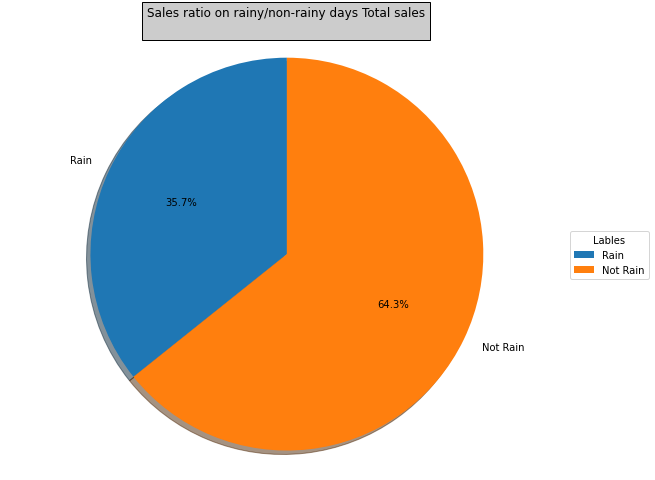

In [218]:
#The percentage of sales on rainy days compared to non-rainy days

labels = ['Rain','Not Rain']
counts_none = [rain_unit,not_rain_unit]

fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.pie(counts_none, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(labels,
          title="Lables",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Sales ratio on rainy/non-rainy days Total sales\n", bbox={'facecolor':'0.8', 'pad':5})
plt.show()

<div style="direction:rtl; font-size:15px;text-align:center">ההפרשים בין ממוצע המכירות בכל חודש לבין הממוצע באותה שנה:</div>

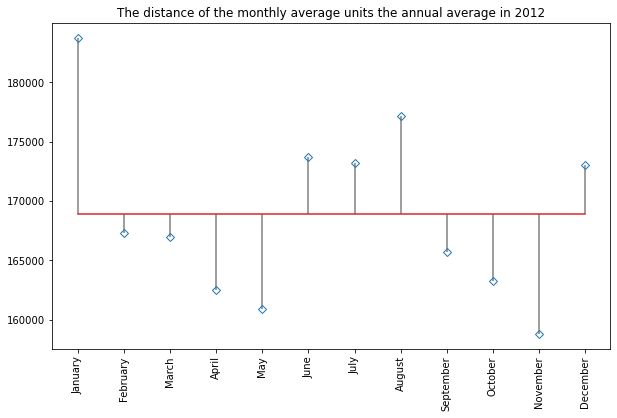

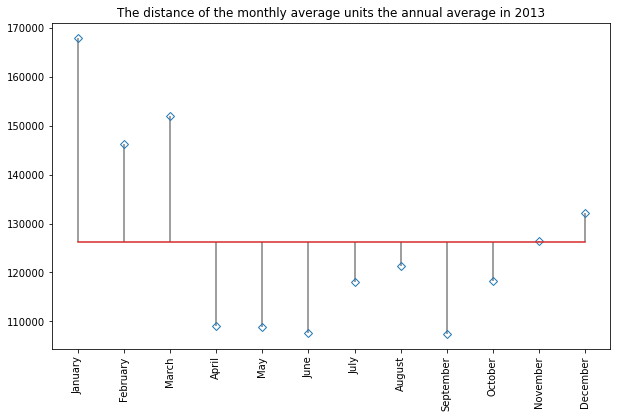

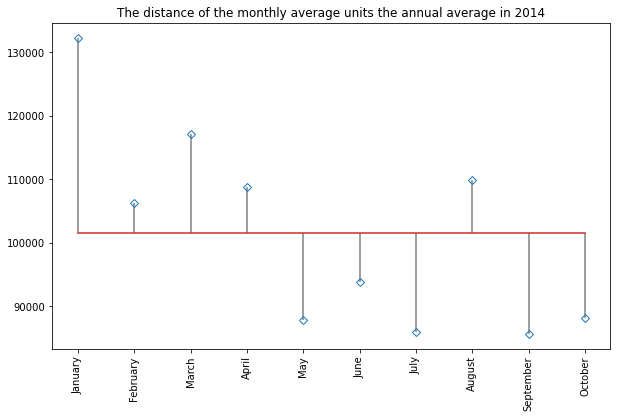

In [219]:
#The differences between the average sales each year and each month during the year in 2012-2014

df_filtered = df[["date","units"]]

grouped_year = df_filtered.groupby(df_filtered['date'].dt.year).sum()
grouped_year=grouped_year["units"].tolist()
grouped_year[0]=grouped_year[0]/12
grouped_year[1]=grouped_year[1]/12
grouped_year[2]=grouped_year[2]/10

grouped_month = df_filtered.groupby([df_filtered['date'].dt.year,df_filtered['date'].dt.month]).sum()
grouped_month=grouped_month["units"].tolist()
labels=['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']

years=['2012','2013','2014']


for i in range(len(years)):
    plt.figure(figsize=(10, 6))
    if(i==0):
        y = grouped_month[0:12]
        x = np.linspace(0, 12, 12)
        plt.xticks(x, labels, rotation='vertical')
    if(i==1):
        y = grouped_month[12:24]
        x = np.linspace(0, 12, 12)
        plt.xticks(x, labels, rotation='vertical')
    if(i==2):
        y = grouped_month[24:]
        x = np.linspace(0, 10, 10)
        plt.xticks(x, labels[0:10], rotation='vertical')
        
    markerline, stemlines, baseline = plt.stem(x,y, linefmt='grey', markerfmt='D', bottom=grouped_year[i])
    markerline.set_markerfacecolor('none')
    plt.title('The distance of the monthly average units the annual average in ' + years[i])
    plt.show()


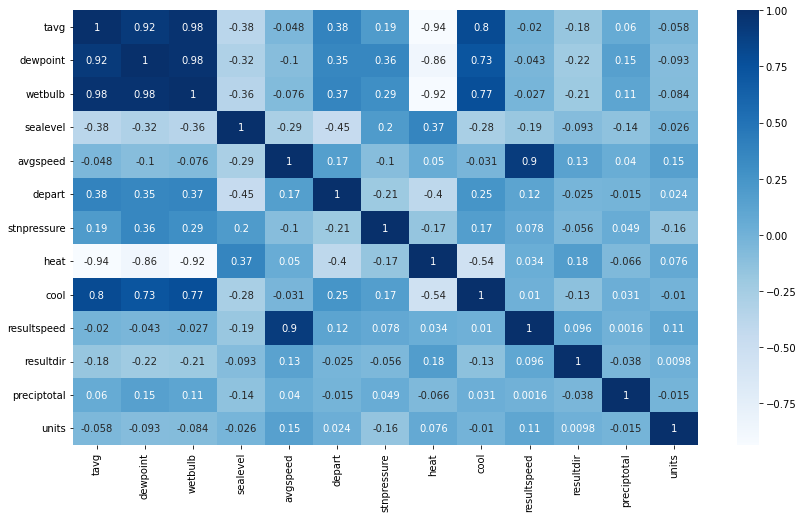

In [220]:
#create heatmap for the features

numeric_features = df[['tavg','dewpoint','wetbulb','sealevel','avgspeed','depart','stnpressure','heat','cool','snowfall','resultspeed',
           'resultdir','preciptotal','units']]

plt.figure(figsize=(14, 8))
sns.heatmap(numeric_features.corr(), annot=True, cmap='Blues')
plt.show()

# Section B

exclusion - מחיקת ערכים לפי קורולציה
transformations - עשינו למעלה (הפכנו את הערכים לנומרי)

### Imputation

In [221]:
df_merge.isnull().sum()  # The sum of the empty variables per feature 

date               0
store_nbr          0
units              0
station_nbr        0
tmax            1004
tmin            1003
tavg            1691
depart         27658
dewpoint         820
wetbulb         1509
heat            1691
cool            1691
sunrise        24149
sunset         24149
codesum        23141
snowfall       14926
preciptotal      891
stnpressure      990
sealevel        1934
resultspeed      680
resultdir        680
avgspeed         914
dtype: int64

<div style="direction:rtl; font-size:15px;">- נמחק שורות שיש להן 12 עמודות חסרות</div>
<div style="direction:rtl; font-size:15px;">- נבצע מחיקת עמודות לפי הקורולציה שהצגנו למעלה</div>
<div style="direction:rtl; font-size:15px;">- tmax,tmin מחקנו כי את הממוצע ולכן בחרנו אותו</div>
<div style="direction:rtl; font-size:15px;">- depart,sunrise,sunset יותר מחצי מהשורות מכילות מידע חסר בעמודות אלה ולכן מחקנו</div>

In [222]:
df_merge.dropna(thresh=12, axis=0, inplace=True) # drop observations that don't have at least 12 features

#Performs a column deletion according to the correlation we presented above
#we drop tmax and tmin beacause we have tavg and is more accurate
df_merge.drop(['tmax', 'tmin', 'dewpoint','wetbulb','heat'], axis=1, inplace=True)


# More than 50 percent are empty so we deleted the columns
df_merge.drop(['depart', 'sunrise', 'sunset'], axis=1, inplace=True)

In [223]:
df_merge.shape

(40572, 14)

In [224]:
#We deleted the columns because they have a lot of missing values and this can affect the results
df_merge.isnull().sum()

date               0
store_nbr          0
units              0
station_nbr        0
tavg             668
cool             668
codesum        22192
snowfall       13982
preciptotal        8
stnpressure       95
sealevel        1324
resultspeed      189
resultdir        189
avgspeed          11
dtype: int64

### One-Hot Encoding

<div style="direction:rtl; font-size:15px;">פיצלנו את ה-codesum לעמודות</div>

In [225]:
# get categorical variables after dropping observations
df = df_merge.copy(deep=True)

labels = df['codesum'].tolist()
set_labels=[]
for lab in labels:
    if(lab is not None):
        for l in lab.split():
            set_labels.append(l)        
set_labels=list(set(set_labels)) # get all codesum on db

code_df = pd.DataFrame(columns =set_labels)
# add new encoded variables to the dataframe
df = pd.concat([df, code_df], axis=1)

for row in df.itertuples():
    for code in set_labels:
        if(row[7] is not None and code in row[7].split()):
            df.at[row[0],code]=1
            
for code in set_labels:
    df[code].replace(np.NaN, 0, inplace=True)
         
# drop categorical variables
df.drop(['codesum'], axis=1, inplace=True)

for code in set_labels:
    df = df.astype({code: 'int32'}, errors='raise') 

In [226]:
df

,date,store_nbr,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,...,TSSN,MIFG,GR,SN,SQ,TS,TSRA,FG+,FZRA,FU
0,2012-01-01,1,32,1.0,42.0,0.0,None,0.05,29.780001,29.920000,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-01,2,406,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-01,3,326,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-01,4,82,9.0,27.0,0.0,None,T,29.340000,30.090000,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-01,5,41,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,2014-10-31,41,52,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,...,0,0,0,0,0,0,0,0,0,0
41596,2014-10-31,42,64,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,...,0,0,0,0,0,0,0,0,0,0
41597,2014-10-31,43,48,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,...,0,0,0,0,0,0,0,0,0,0
41598,2014-10-31,44,87,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,...,0,0,0,0,0,0,0,0,0,0


<div style="direction:rtl; font-size:15px;">פיצלנו את התאריך לעמודות של יום חודש ושנה  (31+12+3)</div>

In [227]:
days=['1d','2d','3d','4d','5d','6d','7d','8d','9d','10d','11d','12d','13d','14d','15d','16d','17d','18d','19d','20d',
      '21d','22d','23d','24d','25d','26d','27d','28d','29d','30d','31d']
months=['1m','2m','3m','4m','5m','6m','7m','8m','9m','10m','11m','12m']
years=[2012,2013,2014]
days_df = pd.DataFrame(columns =days)
months_df = pd.DataFrame(columns =months)
years_df = pd.DataFrame(columns =years)

pdLists = [days_df, months_df, years_df]
date_df = pd.concat(pdLists)

df['date'] = pd.to_datetime(df_merge['date'])
df = pd.concat([df, date_df], axis=1)

<div style="direction:rtl; font-size:15px;">השמה של 1 במקום של התאריך</div>

In [228]:
for row in df.itertuples(): #השמה של 1 במקום שבו התאריך מתקיים
    df.at[row[0],str(row[1].day)+'d']=1
    df.at[row[0],str(row[1].month )+'m']=1
    df.at[row[0],row[1].year]=1


<div style="direction:rtl; font-size:15px;">השמה של 0 במקומות החסרים והפיכת השדה לסוג שתופס פחות מקום</div>

In [229]:
for i in range(1,32):
    df[str(i)+'d'].replace(np.NaN, 0, inplace=True)
for i in range(1,13):
    df[str(i)+'m'].replace(np.NaN, 0, inplace=True)
for i in range(2012,2015):
    df[i].replace(np.NaN, 0, inplace=True)

# int32 is more efficient in terms of storage

for i in range(1,32):
    df= df.astype({str(i)+'d': 'int32'},errors='raise')
for i in range(1,13):
    df = df.astype({str(i)+'m': 'int32'},errors='raise')
for i in range(2012,2015):
    df = df.astype({i: 'int32'},errors='raise')

In [230]:
df

,date,store_nbr,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,...,6m,7d,7m,8d,8m,9d,9m,2012,2013,2014
0,2012-01-01,1,32,1.0,42.0,0.0,None,0.05,29.780001,29.920000,...,0,0,0,0,0,0,0,1,0,0
1,2012-01-01,2,406,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,...,0,0,0,0,0,0,0,1,0,0
2,2012-01-01,3,326,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,...,0,0,0,0,0,0,0,1,0,0
3,2012-01-01,4,82,9.0,27.0,0.0,None,T,29.340000,30.090000,...,0,0,0,0,0,0,0,1,0,0
4,2012-01-01,5,41,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,2014-10-31,41,52,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,...,0,0,0,0,0,0,0,0,0,1
41596,2014-10-31,42,64,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,...,0,0,0,0,0,0,0,0,0,1
41597,2014-10-31,43,48,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,...,0,0,0,0,0,0,0,0,0,1
41598,2014-10-31,44,87,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,...,0,0,0,0,0,0,0,0,0,1


<div style="direction:rtl; font-size:15px;">פיצול החנויות לעמודות</div>

In [231]:
labels = df['store_nbr'].tolist() # get all store_nbr values
set_labels=[]       
set_labels=list(set(labels))
for i in range(len(set_labels)):
    set_labels[i] = str('store_'+str(set_labels[i]))

stores_df = pd.DataFrame(columns = set_labels)
df = pd.concat([df, stores_df], axis=1)

In [232]:
for row in df.itertuples(): # put 1 on the current store column
    df.at[row[0],str('store_'+str(row[2]))]=1
for store in set_labels:
    df[store].replace(np.NaN, 0, inplace=True)

In [233]:
df

,date,store_nbr,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
0,2012-01-01,1,32,1.0,42.0,0.0,None,0.05,29.780001,29.920000,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-01,2,406,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-01,3,326,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-01,4,82,9.0,27.0,0.0,None,T,29.340000,30.090000,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-01,5,41,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,2014-10-31,41,52,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,...,0,0,0,0,0,1,0,0,0,0
41596,2014-10-31,42,64,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,...,0,0,0,0,0,0,1,0,0,0
41597,2014-10-31,43,48,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,...,0,0,0,0,0,0,0,1,0,0
41598,2014-10-31,44,87,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,...,0,0,0,0,0,0,0,0,1,0


In [234]:
# For section C
dates_df = df['date']
stores_df = df['store_nbr']

df_section_D = df.copy(deep=True) #copy DF for section D

In [235]:
#Change T value to 0
df.replace({' T':float(0)}, inplace=True) 
df.replace({'T':float(0)}, inplace=True)
df.replace({'  T':float(0)}, inplace=True)


In [236]:
# drop the columns we made for them one hot encoding
df.drop(['date'], axis=1, inplace=True)
df.drop(['store_nbr'], axis=1, inplace=True)

features = ['tavg','sealevel','avgspeed','stnpressure','cool','snowfall','resultspeed',
           'resultdir','preciptotal']

df=df_to_numeric(df,features)

In [237]:
# use KNN to impute missing values

imputer = KNNImputer(n_neighbors=5, weights="distance")
imputed = imputer.fit_transform(df)

# replace values in the dataset with new imputed values
df[df.columns] = imputed

df_Section_F = df.copy(deep=True) #copy DF for section F

In [238]:
# missing values by variable
df.isna().sum()

units          0
station_nbr    0
tavg           0
cool           0
snowfall       0
              ..
store_41       0
store_42       0
store_43       0
store_44       0
store_45       0
Length: 130, dtype: int64

# Section C

In [112]:
df_merge = df.copy(deep=True)
df_merge

,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
0,32.0,1.0,42.0,0.0,0.0,0.05,29.780001,29.920000,3.600000,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,406.0,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,11.400000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,326.0,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,10.300000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,82.0,9.0,27.0,0.0,0.0,0.00,29.340000,30.090000,22.799999,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.0,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,4.400000,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,52.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41596,64.0,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,11.900000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
41597,48.0,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,5.300000,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41598,87.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<div style="direction:rtl; font-size:15px;">החזרנו את עמודת התאריך והחנות לצורך ה- group by</div>

In [113]:
df_merge = df_merge.assign(date=dates_df)
df_merge

,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,...,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45,date
0,32.0,1.0,42.0,0.0,0.0,0.05,29.780001,29.920000,3.600000,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01
1,406.0,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,11.400000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01
2,326.0,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,10.300000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01
3,82.0,9.0,27.0,0.0,0.0,0.00,29.340000,30.090000,22.799999,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01
4,41.0,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,4.400000,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,52.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2014-10-31
41596,64.0,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,11.900000,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2014-10-31
41597,48.0,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,5.300000,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-31
41598,87.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2014-10-31


In [114]:
df_merge = df_merge.assign(store_nbr=stores_df)
df_merge

,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,...,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45,date,store_nbr
0,32.0,1.0,42.0,0.0,0.0,0.05,29.780001,29.920000,3.600000,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01,1
1,406.0,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,11.400000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01,2
2,326.0,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,10.300000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01,3
3,82.0,9.0,27.0,0.0,0.0,0.00,29.340000,30.090000,22.799999,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01,4
4,41.0,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,4.400000,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2012-01-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,52.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2014-10-31,41
41596,64.0,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,11.900000,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2014-10-31,42
41597,48.0,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,5.300000,30.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2014-10-31,43
41598,87.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2014-10-31,44


In [115]:
df_merge.drop(['units'], axis=1, inplace=True) # drop units columns and later we add the key_sum

<div style="direction:rtl; font-size:15px;">פיצול המוצרים לעמודות</div>

In [116]:
labels = df_sales['item_nbr'].tolist() # get all store_nbr values
set_labels=[]       
set_labels=list(set(labels))
for i in range(len(set_labels)):
    set_labels[i] = str('item_'+str(set_labels[i]))

df = df_sales.copy(deep=True)
items_df = pd.DataFrame(columns = set_labels)
df = pd.concat([df, items_df], axis=1)

In [117]:
items =[5, 6, 9, 16, 45] # only this columns stay on df
set_labels.remove('item_5')
set_labels.remove('item_6')
set_labels.remove('item_9')
set_labels.remove('item_16')
set_labels.remove('item_45')
df.drop(set_labels, axis=1, inplace=True) # Leave only the selected items columns

In [118]:
df = df[df.item_nbr.isin(items)]
df

,date,store_nbr,item_nbr,units,item_5,item_6,item_9,item_16,item_45
4,2012-01-01,1,5,0,NaN,NaN,NaN,NaN,NaN
5,2012-01-01,1,6,0,NaN,NaN,NaN,NaN,NaN
8,2012-01-01,1,9,29,NaN,NaN,NaN,NaN,NaN
15,2012-01-01,1,16,0,NaN,NaN,NaN,NaN,NaN
44,2012-01-01,1,45,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4617493,2014-10-31,45,5,0,NaN,NaN,NaN,NaN,NaN
4617494,2014-10-31,45,6,0,NaN,NaN,NaN,NaN,NaN
4617497,2014-10-31,45,9,10,NaN,NaN,NaN,NaN,NaN
4617504,2014-10-31,45,16,0,NaN,NaN,NaN,NaN,NaN


In [119]:
for row in df.itertuples():
    df.at[row[0],str('item_'+str(row[3]))] = row[4] # change the value of item column to the unit value
    
for i in items:
    df[str('item_'+str(i))].replace(np.NaN, 0, inplace=True) # put 0 on the other columns of items
     
df["key_sum"] = np.NaN # add key_sum column
df

,date,store_nbr,item_nbr,units,item_5,item_6,item_9,item_16,item_45,key_sum
4,2012-01-01,1,5,0,0,0,0,0,0,NaN
5,2012-01-01,1,6,0,0,0,0,0,0,NaN
8,2012-01-01,1,9,29,0,0,29,0,0,NaN
15,2012-01-01,1,16,0,0,0,0,0,0,NaN
44,2012-01-01,1,45,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...
4617493,2014-10-31,45,5,0,0,0,0,0,0,NaN
4617494,2014-10-31,45,6,0,0,0,0,0,0,NaN
4617497,2014-10-31,45,9,10,0,0,10,0,0,NaN
4617504,2014-10-31,45,16,0,0,0,0,0,0,NaN


In [120]:
#group by the store and date , and put value on key_sum column

df_item = df.groupby(by=['date','store_nbr'],as_index=False).sum()
df_item["key_sum"] = df_item['units']
df_item.drop(['units','item_nbr'], axis=1, inplace=True)
df_item


,date,store_nbr,item_5,item_6,item_9,item_16,item_45,key_sum
0,2012-01-01,1,0,0,29,0,0,29
1,2012-01-01,2,191,0,0,0,0,191
2,2012-01-01,3,214,0,0,0,112,326
3,2012-01-01,4,0,0,61,0,0,61
4,2012-01-01,5,0,0,0,24,0,24
...,...,...,...,...,...,...,...,...
41595,2014-10-31,41,0,0,0,30,0,30
41596,2014-10-31,42,29,0,0,0,35,64
41597,2014-10-31,43,0,0,0,39,0,39
41598,2014-10-31,44,47,0,0,0,0,47


In [121]:
# check which row are exist in the df_merge db and sale_df that we build (becuse we drop row on section B)
duplicates = set(df_item.index).intersection(df_merge.index)

for row in df_item.itertuples():
    if(row[0] not in duplicates): 
        df_item = df_item.drop([row[0]], axis=0)
df_item

,date,store_nbr,item_5,item_6,item_9,item_16,item_45,key_sum
0,2012-01-01,1,0,0,29,0,0,29
1,2012-01-01,2,191,0,0,0,0,191
2,2012-01-01,3,214,0,0,0,112,326
3,2012-01-01,4,0,0,61,0,0,61
4,2012-01-01,5,0,0,0,24,0,24
...,...,...,...,...,...,...,...,...
41595,2014-10-31,41,0,0,0,30,0,30
41596,2014-10-31,42,29,0,0,0,35,64
41597,2014-10-31,43,0,0,0,39,0,39
41598,2014-10-31,44,47,0,0,0,0,47


In [122]:
result= pd.merge(left = df_item, right = df_key, how = 'inner' , on = 'store_nbr') 
result['date'] = pd.to_datetime(result['date']) # כדי שיהיה סוג נתונים אחיד
result # column station_nbr added

# The database shows each store all the dates from 2012-2014, the print shows in the order of the stores

,date,store_nbr,item_5,item_6,item_9,item_16,item_45,key_sum,station_nbr
0,2012-01-01,1,0,0,29,0,0,29,1
1,2012-01-02,1,0,0,60,0,0,60,1
2,2012-01-03,1,0,0,15,0,0,15,1
3,2012-01-04,1,0,0,20,0,0,20,1
4,2012-01-05,1,0,0,16,0,0,16,1
...,...,...,...,...,...,...,...,...,...
40567,2013-09-26,35,0,0,0,28,0,28,5
40568,2013-09-27,35,0,0,0,15,0,15,5
40569,2013-09-28,35,0,0,0,35,0,35,5
40570,2013-09-29,35,0,0,0,23,0,23,5


<div style="direction:rtl; font-size:15px;">כעת נבנה את מסד הנתונים השלם שלנו שאיתו נעבוד</div>

In [123]:
df_new_merge=pd.merge(left = result, right = df_merge, how = 'inner' , on = ['station_nbr','date','store_nbr'])
df_new_merge.drop(['store_nbr','date'], axis=1, inplace=True)
df_new_merge

,item_5,item_6,item_9,item_16,item_45,key_sum,station_nbr,tavg,cool,snowfall,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
0,0,0,29,0,0,29,1,42.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,60,0,0,60,1,41.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,15,0,0,15,1,22.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,20,0,0,20,1,19.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,16,0,0,16,1,32.0,0.0,0.020995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40567,0,0,0,28,0,28,5,58.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40568,0,0,0,15,0,15,5,59.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40569,0,0,0,35,0,35,5,61.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40570,0,0,0,23,0,23,5,58.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div style="direction:rtl; font-size:15px;">הכנת הנתונים עבור ה- Regression </div>

In [124]:
X_train = df_new_merge[(df_new_merge[2012]==1 ) | (df_new_merge[2013]==1)]
X_train.drop(['key_sum','item_5','item_6','item_9','item_16','item_45'], axis=1, inplace=True)

Y_train = df_new_merge[(df_new_merge[2012]==1 ) | (df_new_merge[2013]==1)]
Y_train= Y_train['key_sum']

X_test= df_new_merge[df_new_merge[2014] == 1]
X_test.drop(['key_sum','item_5','item_6','item_9','item_16','item_45'], axis=1, inplace=True)

Y_test= df_new_merge[df_new_merge[2014] == 1]['key_sum']

In [125]:
df = df_new_merge.copy(deep=True)

# Gradient Boosting Regressor

In [126]:
gb = GradientBoostingRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'learning_rate': [0.5, 1, 1.5],
    'n_estimators': [50, 100]
}

# define grid search
grid_search = GridSearchCV(estimator=gb, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate MSE
MSE = round(mean_squared_error(Y_test, y_pred), 3)

df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Gradient Boosting Regressor'}, columns={0: 'MSE'})
df

,MSE
Gradient Boosting Regressor,1270.107


# Decision Tree Regressor

In [127]:
dt = DecisionTreeRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate MSE
MSE = round(mean_squared_error(Y_test, y_pred), 3)

df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Decision Tree Regressor'}, columns={0: 'MSE'})
df

,MSE
Decision Tree Regressor,2209.228


# Random Forest Regressor

In [128]:
# define model
rf = RandomForestRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 8],
    'n_estimators': [20, 50]
}

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate MSE
MSE = round(mean_squared_error(Y_test, y_pred), 3)

df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'Random Forest Regressor'}, columns={0: 'MSE'})
df

,MSE
Random Forest Regressor,2209.228


# AdaBoost Regressor

In [129]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

# define model
ab = AdaBoostRegressor(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'n_estimators': [20, 50]
}

# define grid search
grid_search = GridSearchCV(estimator=ab, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate MSE
MSE = round(mean_squared_error(Y_test, y_pred), 3)

df = pd.DataFrame([MSE]).T
df = df.rename(index={0: 'AdaBoost Regressor'}, columns={0: 'MSE'})
df

,MSE
AdaBoost Regressor,2570.273


# Section D

In [130]:
df_section_D.drop(['store_nbr'], axis=1, inplace=True)
df_section_D

,date,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
0,2012-01-01,32,1.0,42.0,0.0,None,0.05,29.780001,29.920000,3.600000,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-01,406,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,11.400000,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-01,326,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,10.300000,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-01,82,9.0,27.0,0.0,None,T,29.340000,30.090000,22.799999,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-01,41,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,4.400000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,2014-10-31,52,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,...,0,0,0,0,0,1,0,0,0,0
41596,2014-10-31,64,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,11.900000,...,0,0,0,0,0,0,1,0,0,0
41597,2014-10-31,48,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,5.300000,...,0,0,0,0,0,0,0,1,0,0
41598,2014-10-31,87,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,...,0,0,0,0,0,0,0,0,1,0


In [131]:
df_section_D = df_section_D[df_section_D['store_11'] == 1] # select only store_11
df_section_D = df_section_D.reset_index()
df_section_D

,index,date,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
0,10,2012-01-01,122,10.0,63.0,0.0,None,0.00,30.160000,30.190001,...,0,0,0,0,0,0,0,0,0,0
1,54,2012-01-02,120,10.0,55.0,0.0,None,0.00,30.110001,30.139999,...,0,0,0,0,0,0,0,0,0,0
2,98,2012-01-03,94,10.0,41.0,0.0,None,0.00,30.270000,30.330000,...,0,0,0,0,0,0,0,0,0,0
3,142,2012-01-04,109,10.0,43.0,0.0,None,0.00,30.350000,30.379999,...,0,0,0,0,0,0,0,0,0,0
4,186,2012-01-05,109,10.0,52.0,0.0,None,0.00,30.200001,30.209999,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,41385,2014-10-27,52,10.0,78.0,13.0,None,0.00,30.020000,30.059999,...,0,0,0,0,0,0,0,0,0,0
894,41430,2014-10-28,30,10.0,77.0,12.0,None,0.00,30.110001,30.129999,...,0,0,0,0,0,0,0,0,0,0
895,41475,2014-10-29,78,10.0,77.0,12.0,None,0.00,30.030001,30.040001,...,0,0,0,0,0,0,0,0,0,0
896,41520,2014-10-30,59,10.0,75.0,10.0,None,0.30,29.910000,29.930000,...,0,0,0,0,0,0,0,0,0,0


<div style="direction:rtl; font-size:15px;"> נזרוק את כל עמודות החנויות שאינן 11 (מידע מיותר) ואת העמודות שהורדנו מקודם</div>

In [132]:
df_section_D.drop(['date','index','station_nbr','tavg','cool','snowfall','stnpressure','sealevel','resultspeed','resultdir','avgspeed'], axis=1, inplace=True)
df_section_D.drop(codesum_labels, axis=1, inplace=True)
stores_id = [str('store_'+ str(i)) for i in range(1,46)]
stores_id.remove('store_11')
df_section_D.drop(stores_id, axis=1, inplace=True)
df_section_D

,units,preciptotal,10d,10m,11d,11m,12d,12m,13d,14d,...,7d,7m,8d,8m,9d,9m,2012,2013,2014,store_11
0,122,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,120,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,94,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,109,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,109,0.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,52,0.00,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
894,30,0.00,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
895,78,0.00,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
896,59,0.30,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


<div style="direction:rtl; font-size:15px;">היכן ששדה preciptotal גדול מ-0 נוסיף True עבור יום שירד בו גשם אחרת False </div>

In [133]:
for row in df_section_D.itertuples():
    flag=0
    if(row[2] == 'T' or row[2] == ' T' or row[2] == '  T'):
        df_section_D.at[row[0],'preciptotal']=True
        flag=1
    if(flag == 0 and float(row[2]) > 0):
        df_section_D.at[row[0],'preciptotal']=True
    if(flag == 0 and float(row[2]) == 0):
        df_section_D.at[row[0],'preciptotal']=False

df_section_D.rename(columns = {'preciptotal':'Is_Rainy'}, inplace = True)
df_section_D

,units,Is_Rainy,10d,10m,11d,11m,12d,12m,13d,14d,...,7d,7m,8d,8m,9d,9m,2012,2013,2014,store_11
0,122,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,120,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,94,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,109,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,109,False,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,52,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
894,30,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
895,78,False,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
896,59,True,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [134]:
df_section_D.replace({'False': 0}, inplace=True)
df_section_D.replace({'True': 1}, inplace=True)

<div style="direction:rtl; font-size:15px;">הכנת הנתונים עבור ה- Classfication </div>

In [135]:
X_train = df_section_D[(df_section_D[2012]==1 ) | (df_section_D[2013]==1)]
X_train.drop(['Is_Rainy'], axis=1, inplace=True)

Y_train=df_section_D[(df_section_D[2012]==1 )| (df_section_D[2013]==1)]['Is_Rainy']

X_test= df_section_D[df_section_D[2014]==1]
X_test.drop(['Is_Rainy'], axis=1, inplace=True)

Y_test= df_section_D[df_section_D[2014]==1]['Is_Rainy']

# Decision Tree Classifier

In [136]:
# define model
dt = DecisionTreeClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [2, 3],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [2, 8]
}

# define grid search
grid_search = GridSearchCV(estimator=dt, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate accuracy
acc = round(accuracy_score(Y_test, y_pred), 3)
sensitivity, specificity = get_metrics(Y_test, y_pred)

# display metrics
df = pd.DataFrame([acc, sensitivity, specificity]).T
df = df.rename(index={0: 'Decision Tree Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})
df

#אין לנו הרבה תצפיות ולכן הדיוק נמוך

,Accuracy,Sensitivity,Specificity
Decision Tree Classifier,0.59,0.418,0.756


# Random Forest Classifier

In [137]:
# define model
rf = RandomForestClassifier(random_state=RSEED)

# define parameter grid
parameters_grid = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 4, 6],
    'n_estimators': [20, 50, 80]
}

# define grid search
grid_search = GridSearchCV(estimator=rf, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate metrics
acc = round(accuracy_score(Y_test, y_pred), 3)
sensitivity, specificity = get_metrics(Y_test, y_pred)

# display metrics
rf_df = pd.DataFrame([acc, sensitivity, specificity]).T
rf_df = rf_df.rename(index={0: 'Random Forest Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})
rf_df

,Accuracy,Sensitivity,Specificity
Random Forest Classifier,0.59,0.508,0.669


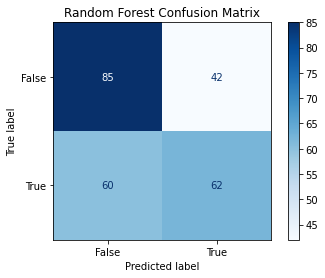

In [138]:
plot_confusion_matrix(best, X_test, Y_test, cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# K Neighbors Classifier

In [139]:
# define model
knn = KNeighborsClassifier()

# define parameter grid
parameters_grid = {
    'n_neighbors': [3, 5, 7, 9, 13, 15, 17, 19, 21, 23, 25],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

# define grid search
grid_search = GridSearchCV(estimator=knn, param_grid=parameters_grid, cv=10)

# fit estimator
grid_search.fit(X_train, Y_train)

# get best estimator
best = grid_search.best_estimator_

# predict
y_pred = best.predict(X_test)

# calculate metrics
acc = round(accuracy_score(Y_test, y_pred), 3)
sensitivity, specificity = get_metrics(Y_test, y_pred)

# display metrics
knn_df = pd.DataFrame([acc, sensitivity, specificity]).T
knn_df = knn_df.rename(index={0: 'KNN Classifier'}, columns={0: 'Accuracy', 1: 'Sensitivity', 2: 'Specificity'})
knn_df

,Accuracy,Sensitivity,Specificity
KNN Classifier,0.462,0.402,0.52


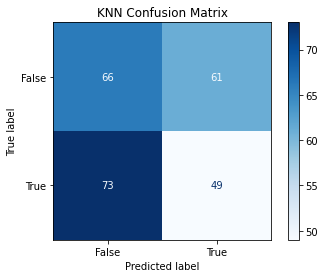

In [140]:
# plot confusion metrics
plot_confusion_matrix(best, X_test, Y_test, cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.show()

# Section E

הסבר על חישוב הגובה לקחנו מפה:
    
https://www.brisbanehotairballooning.com.au/wp-content/uploads/altitude-of-pressure-level-formula.png

$$ H = \frac{10 ^ \frac{\log_{10} (\frac{PF}{PS})}{5.2558797}-1}{-6.8755856 * 10 ^{(-6)}}$$

PF = Pressure at the station level <br>
PS = Pressure at the sea level


In [141]:
df_weather_group = df_to_numeric(df_weather,['stnpressure','sealevel'])
df_weather_group = df_weather_group.groupby('station_nbr').mean()
df_weather_group

,stnpressure,sealevel
station_nbr,,
1,29.848089,30.013399
2,28.905161,30.008886
3,29.279331,29.997084
4,29.317944,30.004498
5,NaN,30.029877
6,29.479000,29.998808
7,28.627573,29.989840
8,29.655474,NaN
9,29.221010,29.994095


In [142]:
df_weather_group.assign(Elevation=None)

for row in df_weather_group.itertuples():
    H = (10 ** (math.log10(row[1]/row[2]) / 5.2558797) -1) / (-6.8755856 * 10 **(-6))
    df_weather_group.at[row[0],'Elevation']= H
            

In [143]:
df_weather_group

,stnpressure,sealevel,Elevation
station_nbr,,,
1,29.848089,30.013399,152.756321
2,28.905161,30.008886,1033.286125
3,29.279331,29.997084,668.634333
4,29.317944,30.004498,639.136977
5,NaN,30.029877,NaN
6,29.479000,29.998808,482.894019
7,28.627573,29.989840,1280.764506
8,29.655474,NaN,NaN
9,29.221010,29.994095,720.801543


stations 5 and 8 with unknown elevation because we have missing values

# Section F

In [239]:
df_Section_F

,units,station_nbr,tavg,cool,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,...,store_36,store_37,store_38,store_39,store_40,store_41,store_42,store_43,store_44,store_45
0,32.0,1.0,42.0,0.0,0.0,0.05,29.780001,29.920000,3.600000,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,406.0,14.0,42.0,0.0,0.0,0.00,29.129999,30.520000,11.400000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,326.0,7.0,42.0,0.0,0.0,0.00,29.150000,30.540001,10.300000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,82.0,9.0,27.0,0.0,0.0,0.00,29.340000,30.090000,22.799999,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41.0,12.0,60.0,0.0,0.0,0.00,30.150000,30.190001,4.400000,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,52.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
41596,64.0,14.0,49.0,0.0,0.0,0.00,28.980000,30.360001,11.900000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
41597,48.0,11.0,63.0,0.0,0.0,0.00,29.820000,29.850000,5.300000,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41598,87.0,12.0,68.0,3.0,0.0,0.00,29.799999,29.850000,7.000000,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [241]:
X_train = df_Section_F[(df_Section_F[2012]==1)| (df_Section_F[2013]==1)]
X_train.drop(['station_nbr'], axis=1, inplace=True)

Y_train=df_Section_F[(df_Section_F[2012]==1 )| (df_Section_F[2013]==1)]['station_nbr']

X_test= df_Section_F[df_Section_F[2014]==1]
X_test.drop(['station_nbr'], axis=1, inplace=True)

Y_test= df_Section_F[df_Section_F[2014]==1]['station_nbr']

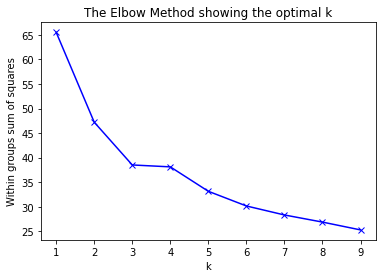

In [242]:
def elbow_met(df):

    # k means determine k
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(df)
        kmeanModel.fit(df)
        distortions.append(sum(np.min(cdist(df, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Within groups sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
elbow_met(df_Section_F)


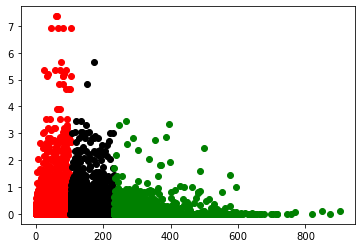

In [386]:
#Import required module
from sklearn.cluster import KMeans
df_Section_F = df_Section_F[df_Section_F.units.isin([5613,3405]) == False] # זורק ערכים חריגים
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df_Section_F)
 
#filter rows of original data
filtered_label0 = df_Section_F[label == 0]
filtered_label1 = df_Section_F[label == 1]
filtered_label2 = df_Section_F[label == 2]
 
# compare between units to preciptotal
#plotting the results
plt.scatter(filtered_label0.iloc[:,0] , filtered_label0.iloc[:,5] , color = 'red')
plt.scatter(filtered_label1.iloc[:,0] , filtered_label1.iloc[:,5] , color = 'black')
plt.scatter(filtered_label2.iloc[:,0] , filtered_label2.iloc[:,5] , color = 'green')

plt.show()